<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/blob/main/Chapter10/Detectron2_Chapter10_Train.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 10 - Train Custom Segmentation Model

## Dataset

In [ ]:
!wget -q https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-Detectron2/raw/main/datasets/segbraintumors_coco.zip
!unzip -q segbraintumors_coco.zip

## Installation

In [ ]:
!python -m pip --quiet install \
'git+https://github.com/facebookresearch/detectron2.git'

## Register datasets

In [ ]:
from detectron2.utils.logger import setup_logger
logger = setup_logger()
from detectron2.data.datasets import register_coco_instances

In [ ]:
# Some configurations
name_ds = "segbraintumors_coco"
name_ds_train = name_ds + "_train"
name_ds_test = name_ds + "_test"
image_root_train = name_ds + "/train"
image_root_test = name_ds + "/test"
af = "_annotations.coco.json"
json_file_train = name_ds + "/train/" + af
json_file_test = name_ds + "/test/" + af

# Register datasets
## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )
## test dataset
register_coco_instances(
    name = name_ds_test,
    metadata = {},
    json_file = json_file_test,
    image_root = image_root_test
    )


## Training configuration

In [ ]:
import os
import torch
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle

output_dir = "output/instance_segmentation"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")
nc = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
# Select a model
config_file_url = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

In [ ]:
# Create a configuration file
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
# Download weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
# Set datasets
cfg.DATASETS.TRAIN = (name_ds_train,)
cfg.DATASETS.TEST = (name_ds_test,)
# Workers
cfg.DATALOADER.NUM_WORKERS = 2
# Solver
cfg.SOLVER.IMS_PER_BATCH = 6
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.STEPS = (3000, 4000)
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.NESTROV = False
cfg.SOLVER.MAX_ITER = 5000
# checkpoint
cfg.SOLVER.CHECKPOINT_PERIOD = 500
# anchors
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[68.33245953, 112.91302277,  89.55701886, 144.71037342,  47.77637482]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.99819939, 0.78726896, 1.23598428]]
# pixels
cfg.MODEL.PIXEL_MEAN = [20.1962, 20.1962, 20.1962]
cfg.MODEL.PIXEL_STD = [39.5985, 39.5985, 39.5985]

# Evaluation
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD
# Classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc
cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = output_dir

In [ ]:
# save configuration file for future use
with open(output_cfg_path, "wb") as f:
  pickle.dump(cfg, f, protocol = pickle.HIGHEST_PROTOCOL)

## Training

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
class BrainTumorTrainer(DefaultTrainer):
  """
  This trainer evaluate data on the `cfg.DATASETS.TEST` validation dataset every `cfg.TEST.EVAL_PERIOD` iterations.
  """
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder == None:
      output_folder = cfg.OUTPUT_DIR
    else:
      output_folder = os.path.join(cfg.OUTPUT_DIR, output_folder)
      os.makedirs(output_folder)
    # Use 
    return COCOEvaluator(dataset_name, distributed=False, output_dir=output_folder)


In [ ]:
from detectron2.engine.hooks import HookBase
import torch
import logging

class BestModelHook(HookBase):
  def __init__(self, cfg, 
               metric   = "segm/AP50", 
               min_max  ="max"):
    self._period = cfg.TEST.EVAL_PERIOD
    self.metric = metric
    self.min_max = min_max
    self.best_value = float("-inf") if min_max == "max" else float("inf")
    logger = logging.getLogger("detectron2")
    logger.setLevel(logging.DEBUG)
    logger.propagate = False
    self._logger = logger
        

  def _take_latest_metrics(self):
    with torch.no_grad():
      latest_metrics = self.trainer.storage.latest()
      return latest_metrics
      
  def after_step(self):
    next_iter = self.trainer.iter + 1
    is_final = next_iter == self.trainer.max_iter
    if is_final or (self._period > 0 and next_iter % self._period == 0):
      latest_metrics = self._take_latest_metrics()
      for (key, (value, iter)) in latest_metrics.items():
        if key == self.metric:
          if (self.min_max == "min" and value < self.best_value) or (self.min_max == "max" and value > self.best_value):
            self._logger.info("Updating best model at iteration {} with {} = {}".format(iter, self.metric, value))
            self.best_value = value
            self.trainer.checkpointer.save("model_best")
            

In [ ]:
import gc
gc.collect()

186

In [ ]:
trainer = BrainTumorTrainer(cfg)
bm_hook = BestModelHook(cfg, 
                        metric  = "segm/AP50", 
                        min_max = "max")
trainer.register_hooks(hooks=[bm_hook])
trainer.train()

[01/12 11:24:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

## Draw Some Samples

In [ ]:
from detectron2.engine import DefaultPredictor
# best model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST  = 0.6
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 
                                 "model_best.pth")
predictor = DefaultPredictor(cfg)

[01/15 11:57:53 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [ ]:
import random
random.seed(42)
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt

def plot_samples(samples, 
                 met        = {}, 
                 is_gt      = True, 
                 predictor  = None):
  n = len(samples)
  nrows = int(-(-n/3)) # ceil
  ncols = 3
  fig, axs = plt.subplots(nrows   = nrows, 
                          ncols   = ncols, 
                          figsize = (21, 7))
  for i,s in enumerate(samples):
    row = i//ncols
    col = i%ncols
    ax = axs[row][col] if len(axs.shape)==2 else axs[i]
    img = cv2.imread(s["file_name"])
    v = Visualizer(img[:,:, ::-1], metadata=met, scale=0.5)
    if is_gt:
      # visualize ground-truths
      v = v.draw_dataset_dict(s)
    else:
      # predict
      outputs = predictor(img)
      # visualize prediction results
      instances = outputs["instances"].to("cpu")
      v = v.draw_instance_predictions(instances)

    ax.imshow(v.get_image())
    ax.axis("off")
  plt.tight_layout()
  plt.show()

def plot_random_samples(name_ds, n=3, predictor=None):
  # access
  ds = DatasetCatalog.get(name_ds)
  met = MetadataCatalog.get(name_ds)
  samples = random.sample(ds, n)
  # plot samples with ground-truths
  plot_samples(samples, met)
  # plot predictions
  plot_samples(samples, 
               met        = met, 
               predictor  = predictor, 
               is_gt      = False)

[01/15 11:58:23 d2.data.datasets.coco]: Loaded 307 images in COCO format from segbraintumors_coco/test/_annotations.coco.json


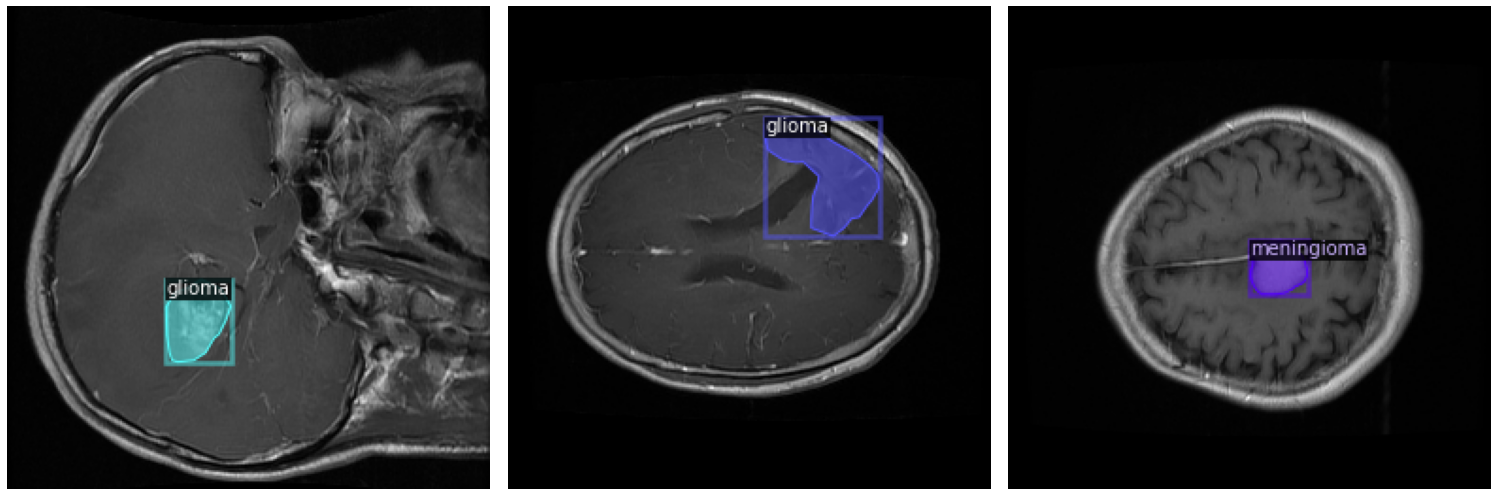

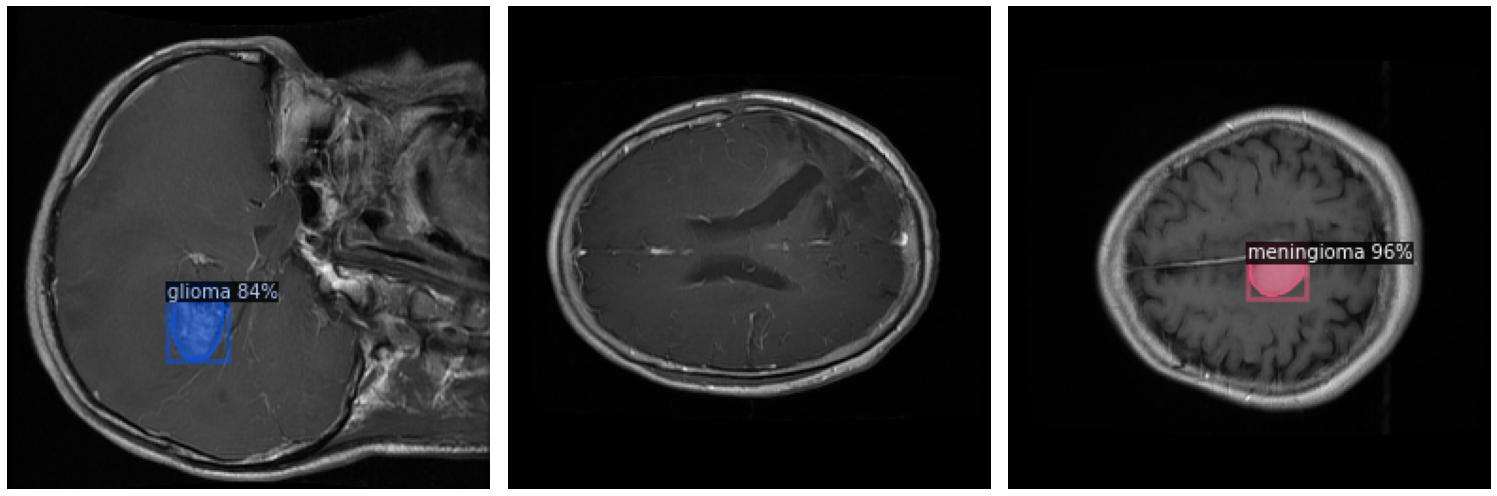

In [ ]:
plot_random_samples(name_ds_test, predictor = predictor)